# Import packages

In [2]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from genetic_selection import GeneticSelectionCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, recall_score, f1_score
from sklearn.metrics import roc_curve, confusion_matrix

df = pd.read_csv("sph6004_assignment1_data.csv")

Print out data shape to know how many patients and how many indicators

In [3]:
print(df.shape)
df.head()

(50920, 162)


,id,aki,gender,admission_age,race,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,...,ggt_max,ld_ldh_min,ld_ldh_max,gcs_min,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable,height,weight_admit
0,36570066,3,F,79.953141,BLACK/AFRICAN AMERICAN,96.0,104.0,100.083333,103.0,126.0,...,NaN,236.0,318.0,15.0,6.0,5.0,4.0,0.0,157.0,110.0
1,39307659,0,F,78.194169,WHITE - RUSSIAN,72.0,134.0,97.263158,97.0,127.0,...,NaN,NaN,NaN,15.0,6.0,5.0,4.0,0.0,NaN,82.0
2,38743306,2,F,65.602396,WHITE,60.0,97.0,84.166667,95.0,143.0,...,NaN,NaN,NaN,15.0,6.0,5.0,4.0,0.0,NaN,62.1
3,32339865,2,F,64.906629,UNKNOWN,59.0,87.0,71.461538,113.0,150.0,...,NaN,NaN,NaN,15.0,1.0,0.0,1.0,1.0,170.0,113.1
4,35526987,2,M,57.438861,WHITE,57.0,100.0,82.387097,81.0,127.0,...,NaN,NaN,NaN,15.0,NaN,0.0,1.0,1.0,178.0,97.4


## Key indicator check
Check whether all patients have aki in their data, otherwise delete that data. Find all patients have aki value

In [4]:
aki_nan_count = 0
for index, row in df.iterrows():
    if row['aki'] not in [0,1,2,3]:
        aki_nan_count += 1
print(aki_nan_count)

0


# Data Preprocessing
## Clean row data
1. As there are so many nan values in the csv file, I need to filter the patients first. Patients with too many nan is meaning less.
2. Here I set the threshold of nan-value ratio to 0.3 so patients need to have less and equal to 30% data that are nan.
3. Filter the data for next step processing (column cleaning)

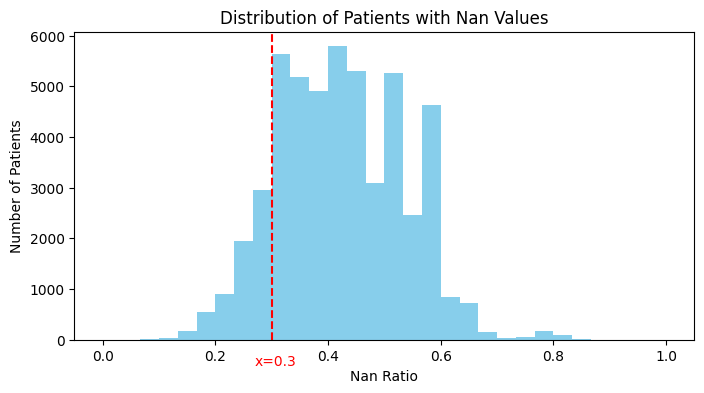

(6537, 162)


,id,aki,gender,admission_age,race,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,...,ggt_max,ld_ldh_min,ld_ldh_max,gcs_min,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable,height,weight_admit
0,36570066,3,F,79.953141,BLACK/AFRICAN AMERICAN,96.0,104.0,100.083333,103.0,126.0,...,NaN,236.0,318.0,15.0,6.0,5.0,4.0,0.0,157.0,110.0
14,31209355,3,M,50.809838,WHITE,32.0,118.0,102.956522,45.0,134.0,...,NaN,166.0,237.0,14.0,6.0,5.0,3.0,0.0,NaN,100.6
23,38695725,2,M,50.054581,UNKNOWN,107.0,122.0,113.962963,75.0,131.0,...,NaN,NaN,NaN,15.0,1.0,0.0,1.0,1.0,NaN,111.0
31,32695241,3,F,59.890014,BLACK/AFRICAN AMERICAN,89.0,114.0,100.538461,82.0,109.0,...,NaN,665.0,960.0,14.0,6.0,4.0,4.0,0.0,NaN,72.8
40,38620864,0,F,27.453982,UNKNOWN,67.0,147.0,87.542857,97.0,157.0,...,NaN,324.0,356.0,14.0,6.0,4.0,4.0,0.0,NaN,63.9


In [5]:
df_row_nan_ratio = df.isnull().sum(axis=1) / len(df.columns)
row_threshold = 0.3
plt.figure(figsize=(8, 4))
plt.hist(df_row_nan_ratio.values, bins=30, range=(0, 1), color='skyblue')
plt.title('Distribution of Patients with Nan Values')
plt.xlabel('Nan Ratio')
plt.ylabel('Number of Patients')
plt.axvline(x=row_threshold, color='red', linestyle='--')
plt.text(row_threshold-0.03, -500, 'x='+str(row_threshold), color='red')
plt.show()

new_df_row_cleaning = df.loc[df_row_nan_ratio <= row_threshold, :]
print(new_df_row_cleaning.shape)
new_df_row_cleaning.head()

## Clean column data
1. For some feature columns, the value is abnormal. So I show max and min value of each column to see whether it is rational.
2. After finding something unrational, then search online resource for some ranges. 
3. These following standard is considered for adults as the minimum age is 18 years old:
* heart rate should be around 40-220
* temperature should be around 34-43
* glucose should be around 40-200
* systolic blood pressure (SBP) should be around 80-200
* weight should be around 30-300
4. Set a threshold to clean column data

First, show max and min value of each column to see whether it is rational

In [6]:
# Create a DataFrame for max and min values for each column
df_max = pd.DataFrame(new_df_row_cleaning.max()).transpose()
df_min = pd.DataFrame(new_df_row_cleaning.min()).transpose()

# Concatenate vertically
result_df = pd.concat([df_max, df_min], axis=0)
result_df.head()

,id,aki,gender,admission_age,race,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,...,ggt_max,ld_ldh_min,ld_ldh_max,gcs_min,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable,height,weight_admit
0,39999230,3,M,97.752882,WHITE - RUSSIAN,143.0,257.0,163.875,165.0,357.0,...,1089.0,22890.0,63325.0,15.0,6.0,5.0,4.0,1.0,215.0,710.0
0,30005707,0,F,18.156133,AMERICAN INDIAN/ALASKA NATIVE,2.0,50.0,41.730769,5.0,59.0,...,6.0,31.0,31.0,3.0,1.0,0.0,1.0,0.0,122.0,1.0


In [7]:
manual_df = new_df_row_cleaning.copy()
# Change the unrational value to nan
heart_rate_list = ['heart_rate_min', 'heart_rate_max', 'heart_rate_mean']
temperature_rate_list = ['temperature_min', 'temperature_max', 'temperature_mean']
glucose_list = ['glucose_min', 'glucose_max', 'glucose_mean']
sbp_list = ['sbp_min', 'sbp_max', 'sbp_mean']

for each in heart_rate_list:
    manual_df.loc[(manual_df[each] > 220) | (manual_df[each] < 50), each] = np.nan

for each in temperature_rate_list:
    manual_df.loc[(manual_df[each] > 43)  | (manual_df[each] < 34), each] = np.nan

for each in glucose_list:
    manual_df.loc[(manual_df[each] > 200) | (manual_df[each] < 40), each] = np.nan

for each in sbp_list:
    manual_df.loc[(manual_df[each] > 200) | (manual_df[each] < 80), each] = np.nan

manual_df.loc[(manual_df['weight_admit'] > 300) | (manual_df['weight_admit'] < 30), 'weight_admit'] = np.nan
print(manual_df.shape)
manual_df.head()

(6537, 162)


,id,aki,gender,admission_age,race,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,...,ggt_max,ld_ldh_min,ld_ldh_max,gcs_min,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable,height,weight_admit
0,36570066,3,F,79.953141,BLACK/AFRICAN AMERICAN,96.0,104.0,100.083333,103.0,126.0,...,NaN,236.0,318.0,15.0,6.0,5.0,4.0,0.0,157.0,110.0
14,31209355,3,M,50.809838,WHITE,NaN,118.0,102.956522,NaN,134.0,...,NaN,166.0,237.0,14.0,6.0,5.0,3.0,0.0,NaN,100.6
23,38695725,2,M,50.054581,UNKNOWN,107.0,122.0,113.962963,NaN,131.0,...,NaN,NaN,NaN,15.0,1.0,0.0,1.0,1.0,NaN,111.0
31,32695241,3,F,59.890014,BLACK/AFRICAN AMERICAN,89.0,114.0,100.538461,82.0,109.0,...,NaN,665.0,960.0,14.0,6.0,4.0,4.0,0.0,NaN,72.8
40,38620864,0,F,27.453982,UNKNOWN,67.0,147.0,87.542857,97.0,157.0,...,NaN,324.0,356.0,14.0,6.0,4.0,4.0,0.0,NaN,63.9


As there are some huge data loss in several feature columns, I need to set a threshold to only keep meaningful columns.

Like what I did in clean row data, I also do the distribution plot to see how is the nan value ratio for each feature column.

Threshold is set to 0.2, which means the tolerance of nan value of each column is 20%.

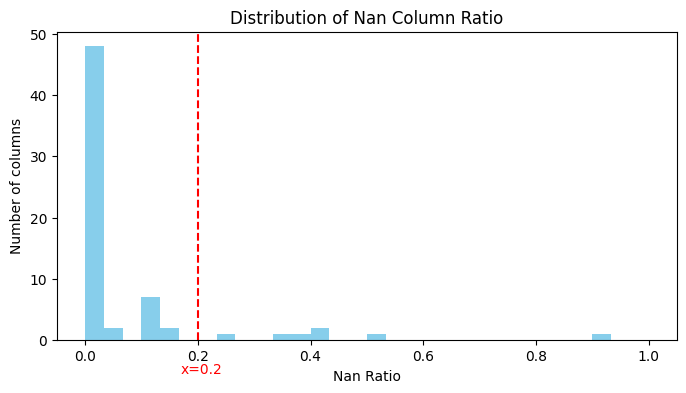

(6537, 59)


,id,aki,gender,admission_age,race,heart_rate_max,heart_rate_mean,dbp_min,dbp_max,dbp_mean,...,potassium_min.1,potassium_max.1,inr_min,inr_max,pt_min,pt_max,ptt_min,ptt_max,gcs_min,gcs_unable
0,36570066,3,F,79.953141,BLACK/AFRICAN AMERICAN,104.0,100.083333,40.0,58.0,47.863636,...,4.8,6.7,1.1,1.1,11.9,12.0,28.6,29.5,15.0,0.0
14,31209355,3,M,50.809838,WHITE,118.0,102.956522,32.0,77.0,55.771429,...,3.0,3.8,3.1,3.6,30.3,34.1,79.0,113.1,14.0,0.0
23,38695725,2,M,50.054581,UNKNOWN,122.0,113.962963,43.0,104.0,65.961538,...,5.1,6.1,1.3,1.3,13.7,14.0,24.5,28.5,15.0,1.0
31,32695241,3,F,59.890014,BLACK/AFRICAN AMERICAN,114.0,100.538461,48.0,77.0,60.880000,...,3.4,4.9,1.3,1.5,14.2,16.8,33.4,39.1,14.0,0.0
40,38620864,0,F,27.453982,UNKNOWN,147.0,87.542857,53.0,128.0,99.040000,...,3.3,3.4,1.0,1.1,11.1,11.9,28.2,28.4,14.0,0.0


In [8]:
df_col_nan_ratio = manual_df.isnull().sum(axis=0) / len(manual_df.columns)
col_threshold = 0.2

plt.figure(figsize=(8, 4))
plt.hist(df_col_nan_ratio.values.flatten(), bins=30, range=(0, 1), color='skyblue')
plt.title('Distribution of Nan Column Ratio')
plt.xlabel('Nan Ratio')
plt.ylabel('Number of columns')
plt.axvline(x=col_threshold, color='red', linestyle='--')
plt.text(col_threshold-0.03, -5.5, 'x='+str(col_threshold), color='red')
plt.show()

new_df_column_cleaning = manual_df.loc[:, df_col_nan_ratio <= col_threshold]
print(new_df_column_cleaning.shape)
new_df_column_cleaning.head()

## Column Value Adjust
For column with name "race", I need to categorize each row as there are some ambiguous and repeatitive items inside.

In [9]:
new_df_after_cleaning = new_df_column_cleaning.copy()

for index, row in new_df_after_cleaning.iterrows():
    if "BLACK" in row['race']:
        new_df_after_cleaning.at[index, 'race'] = "BLACK"
    elif "WHITE" in row['race']:
        new_df_after_cleaning.at[index, 'race'] = "WHITE"
    elif "ASIAN" in row['race']:
        new_df_after_cleaning.at[index, 'race'] = "ASIAN"
    elif "HISPANIC" in row['race'] or "SOUTH AMERICAN" in row['race']:
        new_df_after_cleaning.at[index, 'race'] = "HISPANIC"
    elif "UNABLE" in row['race'] or "UNKNOWN" in row['race'] or "DECLINED" in row['race']:
        new_df_after_cleaning.at[index, 'race'] = "UNKNOWN"
    elif "PORTUGUESE" in row['race']:
        new_df_after_cleaning.at[index, 'race'] = "UNKNOWN"

new_df_after_cleaning.head()

,id,aki,gender,admission_age,race,heart_rate_max,heart_rate_mean,dbp_min,dbp_max,dbp_mean,...,potassium_min.1,potassium_max.1,inr_min,inr_max,pt_min,pt_max,ptt_min,ptt_max,gcs_min,gcs_unable
0,36570066,3,F,79.953141,BLACK,104.0,100.083333,40.0,58.0,47.863636,...,4.8,6.7,1.1,1.1,11.9,12.0,28.6,29.5,15.0,0.0
14,31209355,3,M,50.809838,WHITE,118.0,102.956522,32.0,77.0,55.771429,...,3.0,3.8,3.1,3.6,30.3,34.1,79.0,113.1,14.0,0.0
23,38695725,2,M,50.054581,UNKNOWN,122.0,113.962963,43.0,104.0,65.961538,...,5.1,6.1,1.3,1.3,13.7,14.0,24.5,28.5,15.0,1.0
31,32695241,3,F,59.890014,BLACK,114.0,100.538461,48.0,77.0,60.880000,...,3.4,4.9,1.3,1.5,14.2,16.8,33.4,39.1,14.0,0.0
40,38620864,0,F,27.453982,UNKNOWN,147.0,87.542857,53.0,128.0,99.040000,...,3.3,3.4,1.0,1.1,11.1,11.9,28.2,28.4,14.0,0.0


## Column Trim
1. Transform non-numeric data for column "race" to numeric data, start from 0
2. Column Trim for useless column "id"

In [10]:
list_unique_races = new_df_after_cleaning['race'].unique()
print(list_unique_races)
num_unique_races = len(list_unique_races)
new_df_after_cleaning['race'] = new_df_after_cleaning['race'].replace(list_unique_races,[i for i in range(num_unique_races)])
new_df_after_cleaning['gender'] = new_df_after_cleaning['gender'].replace(['M','F'],[0,1])

# The id column is useless, so I can get rid of it.
new_df_trim =  new_df_after_cleaning.drop(labels = ['id'], axis = 1)
print(new_df_trim.shape)
new_df_trim.head()


['BLACK' 'WHITE' 'UNKNOWN' 'OTHER' 'ASIAN'
 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER' 'HISPANIC'
 'AMERICAN INDIAN/ALASKA NATIVE' 'MULTIPLE RACE/ETHNICITY']
(6537, 58)


,aki,gender,admission_age,race,heart_rate_max,heart_rate_mean,dbp_min,dbp_max,dbp_mean,mbp_min,...,potassium_min.1,potassium_max.1,inr_min,inr_max,pt_min,pt_max,ptt_min,ptt_max,gcs_min,gcs_unable
0,3,1,79.953141,0,104.0,100.083333,40.0,58.0,47.863636,56.0,...,4.8,6.7,1.1,1.1,11.9,12.0,28.6,29.5,15.0,0.0
14,3,0,50.809838,1,118.0,102.956522,32.0,77.0,55.771429,35.0,...,3.0,3.8,3.1,3.6,30.3,34.1,79.0,113.1,14.0,0.0
23,2,0,50.054581,2,122.0,113.962963,43.0,104.0,65.961538,57.0,...,5.1,6.1,1.3,1.3,13.7,14.0,24.5,28.5,15.0,1.0
31,3,1,59.890014,0,114.0,100.538461,48.0,77.0,60.880000,61.0,...,3.4,4.9,1.3,1.5,14.2,16.8,33.4,39.1,14.0,0.0
40,0,1,27.453982,2,147.0,87.542857,53.0,128.0,99.040000,60.0,...,3.3,3.4,1.0,1.1,11.1,11.9,28.2,28.4,14.0,0.0


## Data Imputation
Impute data for those grids with Nan value with mean value of associated columns 

In [11]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(new_df_trim)
new_df_impute = pd.DataFrame(imp_mean.transform(new_df_trim), columns=new_df_trim.columns)
print(new_df_impute.shape)
new_df_impute.head()

(6537, 58)


,aki,gender,admission_age,race,heart_rate_max,heart_rate_mean,dbp_min,dbp_max,dbp_mean,mbp_min,...,potassium_min.1,potassium_max.1,inr_min,inr_max,pt_min,pt_max,ptt_min,ptt_max,gcs_min,gcs_unable
0,3.0,1.0,79.953141,0.0,104.0,100.083333,40.0,58.0,47.863636,56.0,...,4.8,6.7,1.1,1.1,11.9,12.0,28.6,29.5,15.0,0.0
1,3.0,0.0,50.809838,1.0,118.0,102.956522,32.0,77.0,55.771429,35.0,...,3.0,3.8,3.1,3.6,30.3,34.1,79.0,113.1,14.0,0.0
2,2.0,0.0,50.054581,2.0,122.0,113.962963,43.0,104.0,65.961538,57.0,...,5.1,6.1,1.3,1.3,13.7,14.0,24.5,28.5,15.0,1.0
3,3.0,1.0,59.890014,0.0,114.0,100.538461,48.0,77.0,60.880000,61.0,...,3.4,4.9,1.3,1.5,14.2,16.8,33.4,39.1,14.0,0.0
4,0.0,1.0,27.453982,2.0,147.0,87.542857,53.0,128.0,99.040000,60.0,...,3.3,3.4,1.0,1.1,11.1,11.9,28.2,28.4,14.0,0.0


# Data Label
1. Label the patients with aki >0 as kidney failure.
2. Label the patients with aki=0 as normal
Then aki = 1.0 means having kidney failure, aki = 0.0 means normal

In [12]:
for index, row in new_df_impute.iterrows():
    if row['aki'] > 0:
        row['aki'] = 1.0

print(new_df_impute.shape)
new_df_impute.head()

(6537, 58)


,aki,gender,admission_age,race,heart_rate_max,heart_rate_mean,dbp_min,dbp_max,dbp_mean,mbp_min,...,potassium_min.1,potassium_max.1,inr_min,inr_max,pt_min,pt_max,ptt_min,ptt_max,gcs_min,gcs_unable
0,1.0,1.0,79.953141,0.0,104.0,100.083333,40.0,58.0,47.863636,56.0,...,4.8,6.7,1.1,1.1,11.9,12.0,28.6,29.5,15.0,0.0
1,1.0,0.0,50.809838,1.0,118.0,102.956522,32.0,77.0,55.771429,35.0,...,3.0,3.8,3.1,3.6,30.3,34.1,79.0,113.1,14.0,0.0
2,1.0,0.0,50.054581,2.0,122.0,113.962963,43.0,104.0,65.961538,57.0,...,5.1,6.1,1.3,1.3,13.7,14.0,24.5,28.5,15.0,1.0
3,1.0,1.0,59.890014,0.0,114.0,100.538461,48.0,77.0,60.880000,61.0,...,3.4,4.9,1.3,1.5,14.2,16.8,33.4,39.1,14.0,0.0
4,0.0,1.0,27.453982,2.0,147.0,87.542857,53.0,128.0,99.040000,60.0,...,3.3,3.4,1.0,1.1,11.1,11.9,28.2,28.4,14.0,0.0


## Data Split
Split the data into train_set and test_set. Here, 30% of data will be test set and 70% will be train set.

In [13]:
X = new_df_impute.drop(columns=['aki'])
y = new_df_impute['aki'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)

X_train: (4575, 57) X_test: (1962, 57)
y_train: (4575,) y_test: (1962,)


# Feature Selection


In [17]:
def feature_selection(estimator, X_train, y_train):
    feature_selector = GeneticSelectionCV(estimator,
                                            cv=5,   
                                            scoring="accuracy",
                                            max_features=20,
                                            n_population=100,
                                            crossover_proba=0.8,
                                            mutation_proba=0.2,
                                            n_generations=5,
                                            crossover_independent_proba=0.5,
                                            mutation_independent_proba=0.05,
                                            tournament_size=10,
                                            n_gen_no_change=10,
                                            caching=True,
                                            n_jobs=-1)
    
    feature_selector = feature_selector.fit(X_train, y_train.values.ravel())
    selected_features = X_train.columns[feature_selector.support_]
    return selected_features

estimator_dict = {
                  "LogisticRegression" : LogisticRegression(solver="liblinear"),
                  "DecisionTree" : DecisionTreeClassifier(criterion="entropy", max_depth=5),
                  "RandomForest" : RandomForestClassifier(max_depth=5, n_estimators=100, max_samples=1000),
                  "AdaBoost" : AdaBoostClassifier(learning_rate=0.01, n_estimators=50),
                  "GradientBoostingClassifier" : GradientBoostingClassifier(learning_rate=0.1, n_estimators=50, max_depth=5),
                  "SVM" : SVC()
                }

for each_estimator in estimator_dict:
    start = time.time()
    selected_estimator = estimator_dict[each_estimator]
    selected_features = feature_selection(estimator=selected_estimator, X_train=X_train, y_train=y_train)
    time_cost = time.time()-start
    print(each_estimator, ":")
    print("Features Selected:", selected_features)
    print("Selection Time Cost:", round(time_cost, 2), "seconds")
    train(each_estimator, estimator_dict[each_estimator], X_train, X_test, y_train, y_test)
    print("**********************************************************************************************")

LogisticRegression :
Features Selected: Index(['admission_age', 'race', 'dbp_max', 'mbp_min', 'spo2_max', 'spo2_mean',
       'ph_max', 'po2_max', 'pco2_min', 'pco2_max', 'baseexcess_max',
       'aniongap_max', 'bicarbonate_min.1', 'bun_max', 'chloride_max.1',
       'inr_min', 'inr_max', 'gcs_min', 'gcs_unable'],
      dtype='object')
Selection Time Cost: 41.13 seconds
LogisticRegression Training Accuracy Score: 0.856 AUROC:  0.523
LogisticRegression Test Accuracy Score: 0.851 AUROC:  0.517
LogisticRegression Time Cost for Training: 0.54 seconds
**********************************************************************************************
DecisionTree :
Features Selected: Index(['resp_rate_max', 'resp_rate_mean', 'spo2_max', 'baseexcess_max',
       'gcs_unable'],
      dtype='object')
Selection Time Cost: 2.25 seconds
DecisionTree Training Accuracy Score: 0.865 AUROC:  0.606
DecisionTree Test Accuracy Score: 0.828 AUROC:  0.546
DecisionTree Time Cost for Training: 0.07 seconds
*****

**********************************************************************************************
LogisticRegression<br>
Features selected: Index(['heart_rate_max', 'dbp_min', 'dbp_max', 'mbp_mean', 'resp_rate_mean',
       'spo2_max', 'ph_max', 'po2_min', 'baseexcess_max', 'aniongap_min',
       'bun_max', 'glucose_min.2', 'glucose_max.2', 'sodium_min.1',
       'gcs_unable'],
      dtype='object')<br>
Time cost: 37.29048180580139
**********************************************************************************************
DecisionTree<br>
Features selected: Index(['spo2_max', 'ph_max', 'pco2_min', 'hemoglobin_min.1', 'wbc_min',
       'chloride_max.1'],
      dtype='object')<br>
Time cost: 1.7909672260284424
**********************************************************************************************
RandomForest<br>
Features selected: Index(['heart_rate_mean', 'mbp_min', 'spo2_max', 'spo2_mean', 'po2_min',
       'platelets_max'],
      dtype='object')<br>
Time cost: 14.244487524032593
**********************************************************************************************
AdaBoost<br>
Features selected: Index(['spo2_max', 'ph_max'], dtype='object')<br>
Time cost: 10.07372784614563
**********************************************************************************************
GradientBoostingClassifier<br>
Features selected: Index(['admission_age', 'heart_rate_max', 'mbp_max', 'mbp_mean', 'spo2_min',
       'spo2_mean', 'totalco2_min', 'hemoglobin_min.1', 'platelets_min',
       'wbc_min', 'bun_max', 'chloride_min.1', 'glucose_min.2', 'sodium_min.1',
       'potassium_max.1', 'ptt_min', 'gcs_unable'],
      dtype='object')<br>
Time cost: 51.48826456069946 seconds
**********************************************************************************************
SVM<br>
Features selected: Index(['spo2_max', 'spo2_mean'], dtype='object')<br>
Time cost: 18.59532332420349 seconds

In [16]:

def train(model_name, classifier, X_train, X_test, y_train, y_test):

    start_time = time.time()

    classifier = classifier.fit(X_train, y_train.values.ravel())
    y_train_predict =  classifier.predict(X_train)
    y_test_predict = classifier.predict(X_test)

    time_cost = time.time() - start_time

    #training set
    accuracy_score_train = accuracy_score(y_train, y_train_predict)
    roc_auc_train = roc_auc_score(y_train, y_train_predict)

    #test set
    accuracy_score_test = accuracy_score(y_test, y_test_predict)
    roc_auc_test = roc_auc_score(y_test, y_test_predict)

    print(model_name, "Training Accuracy Score:", round(accuracy_score_train, 3), "AUROC: ", round(roc_auc_train, 3))
    print(model_name, "Test Accuracy Score:", round(accuracy_score_test, 3), "AUROC: ", round(roc_auc_test, 3))
    print(model_name, "Time Cost for Training:", round(time_cost, 2), "seconds")
    return y_test_predict, roc_auc_train, roc_auc_test

# Model Evaluation